In [3]:
import pyemma
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns
import ot
import os
from tqdm import tqdm

df = pd.read_csv('ADP_data/A_2D_1ps.dat', header=None, skipinitialspace=True, sep=' ', names=['phi', 'psi'])
points = np.array(df)[10000:15000]
pts = np.array(df)

In [74]:
cluster = pyemma.coordinates.cluster_kmeans(pts[10000:15000], k=50, max_iter=50, stride=10)

/Users/joshhuang/HILDA/HILDA_env/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/joshhuang/HILDA/HILDA_env/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


initialize kmeans++ centers:   0%|          | 0/50 [00:00<?, ?it/s]

kmeans iterations:   0%|          | 0/50 [00:00<?, ?it/s]

In [75]:
print(cluster.dtrajs)
print(np.array(cluster.dtrajs).shape)

[array([ 8, 33,  8, ..., 48, 39, 39], dtype=int32)]
(1, 5000)


/Users/joshhuang/HILDA/HILDA_env/lib/python3.9/site-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


In [76]:
its = pyemma.msm.its(cluster.dtrajs, lags=[1, 2, 5, 10, 20, 50], nits=4, errors='bayes')

estimating BayesianMSM:   0%|          | 0/6 [00:00<?, ?it/s]

<Axes: xlabel='lag time / ps', ylabel='timescale / ps'>

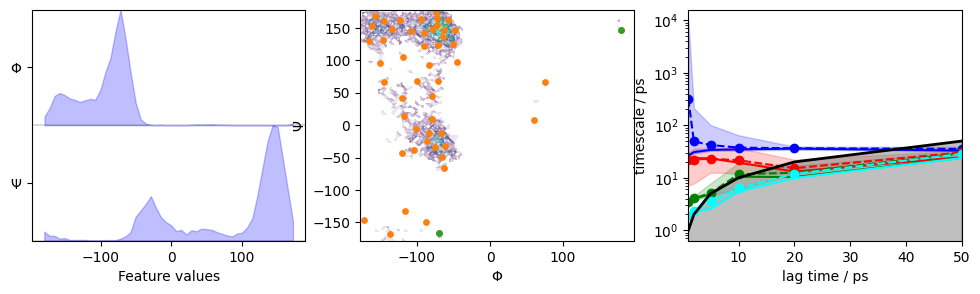

In [77]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

# For the trajectory segments, plot the point of highest density instead of the entire point cloud ... 

pyemma.plots.plot_feature_histograms(pts[10000:15000], feature_labels=['$\Phi$', '$\Psi$'], ax=axes[0])
pyemma.plots.plot_density(*pts[10000:15000].T, ax=axes[1], cbar=False, alpha=0.1)
axes[1].scatter(*cluster.clustercenters.T, s=15, c='C1')
axes[1].scatter(*cluster.clustercenters[28], s=15, c='C2')
axes[1].scatter(*cluster.clustercenters[5], s=15, c='C2')
axes[1].set_xlabel('$\Phi$')
axes[1].set_ylabel('$\Psi$')
pyemma.plots.plot_implied_timescales(its, ax=axes[2], units='ps')

estimating MaximumLikelihoodMSM:   0%|          | 0/9 [00:00<?, ?it/s]

TypeError: legend() takes 0-2 positional arguments but 3 were given

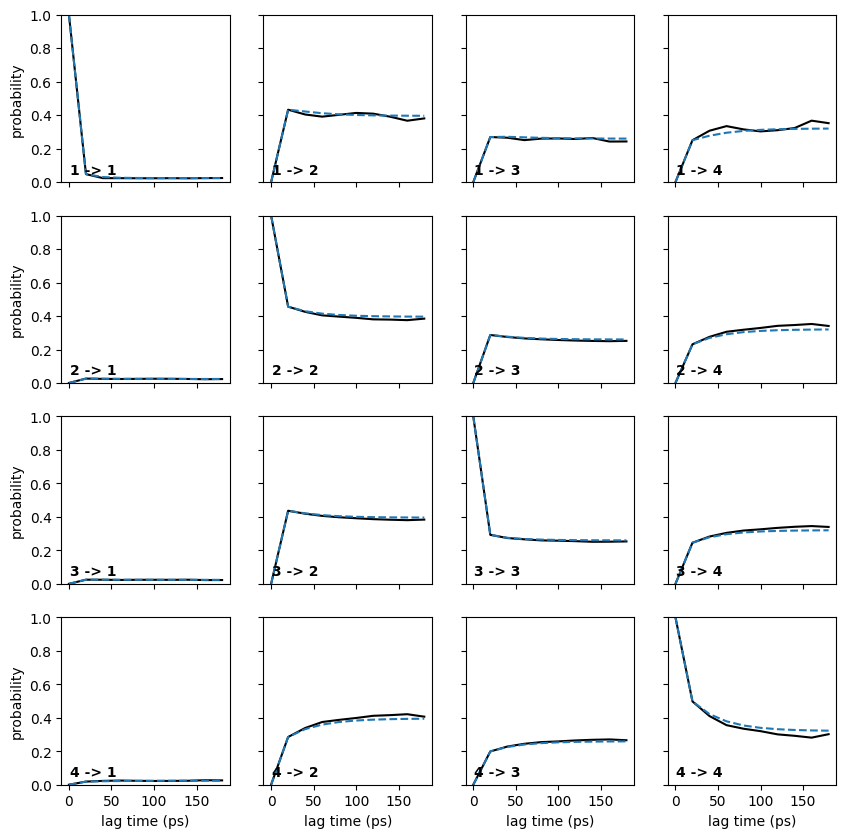

In [134]:
msm = pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=20, dt_traj='1 ps')
pyemma.plots.plot_cktest(msm.cktest(4), units='ps');

In [135]:
msm.metastable_sets

[array([11, 38]),
 array([ 0,  2,  5,  6,  8, 10, 12, 13, 15, 19, 20, 23, 26, 28, 29, 30, 31,
        33, 35, 36, 37, 43, 45, 49]),
 array([ 3, 18, 22, 32, 39, 46, 47, 48]),
 array([ 1,  4,  7,  9, 14, 16, 17, 21, 24, 25, 27, 34, 40, 41, 42, 44])]

In [112]:
msm.metastable_sets[1][0]

0

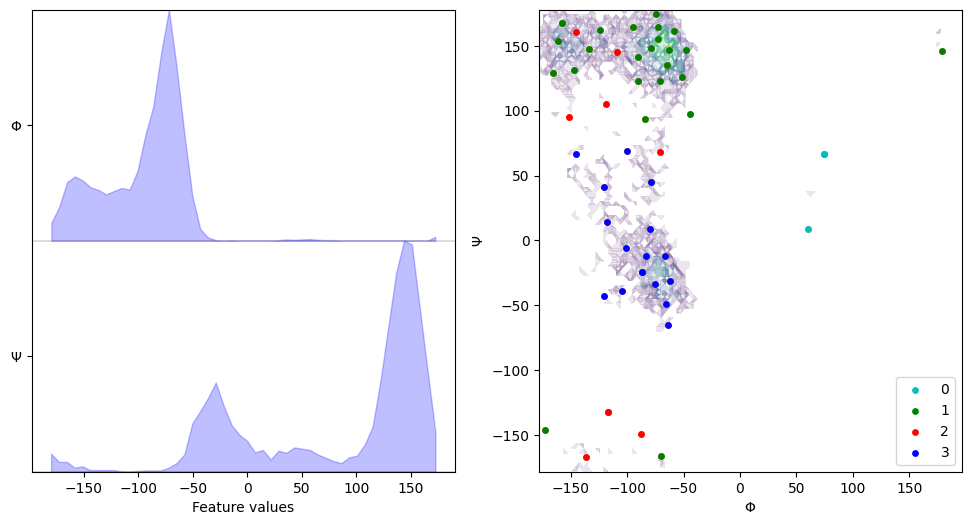

In [113]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# For the trajectory segments, plot the point of highest density instead of the entire point cloud ... 

dict = {0:'c', 1:'g', 2:'r', 3:'b', 4:'m', 5:'b', 6:'orange', 7:'k'}

pyemma.plots.plot_feature_histograms(pts[10000:15000], feature_labels=['$\Phi$', '$\Psi$'], ax=axes[0])
pyemma.plots.plot_density(*pts[10000:15000].T, ax=axes[1], cbar=False, alpha=0.1)

axes[1].scatter(*cluster.clustercenters.T, s=15, c='C1')

for i in range(len(msm.metastable_sets)):
    for j in range(len(msm.metastable_sets[i])):
        axes[1].scatter(*cluster.clustercenters[msm.metastable_sets[i][j]], s=15, c=dict[i])
    axes[1].scatter(*cluster.clustercenters[msm.metastable_sets[i][0]], s=15, c=dict[i],label=i)
#axes[1].scatter(*cluster.clustercenters[28], s=15, c='C2')
#axes[1].scatter(*cluster.clustercenters[8], s=15, c='C2')
axes[1].set_xlabel('$\Phi$')
axes[1].set_ylabel('$\Psi$')
#pyemma.plots.plot_implied_timescales(its, ax=axes[2], units='ps')
axes[1].legend()

#cyan=0, green=1, red=2, blue=3

In [104]:
msm.metastable_sets[1]

array([30, 38])

In [105]:
print(msm.transition_matrix)
print(msm.transition_matrix.shape)

[[0.00952381 0.00947936 0.04255344 ... 0.         0.01895149 0.08530541]
 [0.00851413 0.02542373 0.00422704 ... 0.01693186 0.00847136 0.        ]
 [0.02117705 0.0023421  0.05140187 ... 0.00701915 0.03043578 0.09601627]
 ...
 [0.         0.04259661 0.03187025 ... 0.0212766  0.         0.05324028]
 [0.01621043 0.00806758 0.05231244 ... 0.         0.00806452 0.07260072]
 [0.0356021  0.         0.08052172 ... 0.00983349 0.03542327 0.06692913]]
(50, 50)


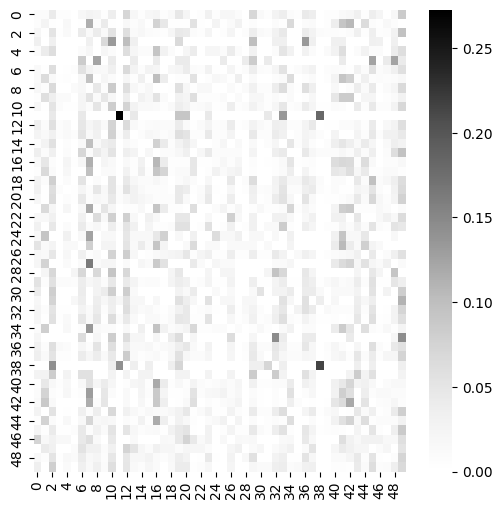

In [106]:
plt.figure(figsize=(6,6))
hm = sns.heatmap(data=msm.transition_matrix,cmap='Greys')

In [131]:
pyemma.msm.PCCA(msm.transition_matrix, 4).metastable_sets


[array([11, 38]),
 array([ 0,  2,  5,  6,  8, 10, 12, 13, 15, 19, 20, 23, 26, 28, 29, 30, 31,
        33, 35, 36, 37, 43, 45, 49]),
 array([ 3, 18, 22, 32, 39, 46, 47, 48]),
 array([ 1,  4,  7,  9, 14, 16, 17, 21, 24, 25, 27, 34, 40, 41, 42, 44])]

In [107]:
inter_state_trans = np.zeros((len(msm.metastable_sets[2]),len(msm.metastable_sets[2])))
add= 0
for i in range(len(msm.metastable_sets[2])):
    for j in range(len(msm.metastable_sets[2])):
        inter_state_trans[i][j] = msm.transition_matrix[msm.metastable_sets[2][i]][msm.metastable_sets[2][j]]

print(inter_state_trans.shape)
print(inter_state_trans.sum())

(35, 35)
29.485810629294864


In [108]:
#Todo: sum the probability of transitioning between macro states.

"""
1) for each metastable macro state i, compute the probability of transitioning to macro state j
  - for each micro state in i compute sum of probabilites of transitioning to each micro state in j
"""

macro_state_transition_mtx = np.zeros((len(msm.metastable_sets), len(msm.metastable_sets)))

for i in range(len(msm.metastable_sets)):
    for j in range(len(msm.metastable_sets)): 
        sum = 0
        for k in msm.metastable_sets[i]:
            for l in msm.metastable_sets[j]:
              sum += msm.transition_matrix[k][l]
        
        macro_state_transition_mtx[i][j] += sum

row_sums = macro_state_transition_mtx.sum(axis=1, keepdims=True)
normalized_macro_transition_matrix = macro_state_transition_mtx / row_sums

print(normalized_macro_transition_matrix)

[[0.27272727 0.18204615 0.54522657 0.        ]
 [0.07133901 0.15880876 0.68882448 0.08102775]
 [0.00165726 0.00823674 0.84245173 0.14765427]
 [0.         0.00591001 0.32467543 0.66941455]]


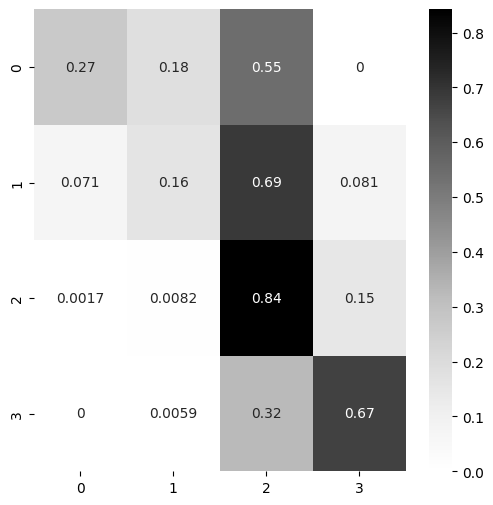

In [109]:
plt.figure(figsize=(6,6))
hm = sns.heatmap(data=normalized_macro_transition_matrix,cmap='Greys', annot=True)

# Segment based MSM

In [49]:
df = pd.read_csv('ADP_data/A_2D_1ps.dat', header=None, skipinitialspace=True, sep=' ', names=['phi', 'psi'])
points = np.array(df)

change_pts_info = pd.read_csv("data/ChangePoints_phi_ws=10_q=0.8_psi_ws=25_q=0.75.txt", delimiter=',',header=None, skipinitialspace=True, names=['CP', 'angle'])

improved_clusters = pd.read_csv("data/ClusterTrajectory_total=100000_K=8_CATBOSSclustering.txt",header=None, skipinitialspace=False)
arr = np.array(improved_clusters)
arr = arr.flatten()

In [50]:
arr_cpi = np.array(change_pts_info)

In [51]:
def construct_combined_states(pts, CPS, start, end):
    unshifted_states = {"metastable": [], "transition": []}
    all_state_cons = []
    for i in range(len(CPS)):
        if i!=0 and i < len(CPS)-1:
            curr_cp = CPS[i][0]
            next_cp = CPS[i+1][0]

            curr_label = CPS[i][1]
            next_label = CPS[i+1][1]
        elif i==0:
            curr_cp = start
            next_cp = CPS[i+1][0]

            curr_label = 'phi'
            next_label = CPS[i+1][1]
        else:
            curr_cp = CPS[i][0]
            next_cp = end

            curr_label = CPS[i][1]
            next_label = 'phi'
        
        unshifted_subseq = pts[curr_cp:next_cp]
        all_state_cons.append(unshifted_subseq)
        if curr_label == 'phi' and next_label == 'phi':
            unshifted_states["metastable"].append(unshifted_subseq)
        elif curr_label == 'phi' and next_label == 'enter_psi':
            unshifted_states["metastable"].append(unshifted_subseq)
        elif curr_label == 'exit_psi' and next_label == 'phi':
            unshifted_states["metastable"].append(unshifted_subseq)
        elif curr_label == 'exit_psi' and next_label == 'enter_psi':
            unshifted_states["metastable"].append(unshifted_subseq)

        else:
            unshifted_states["transition"].append(unshifted_subseq)

    return unshifted_states, all_state_cons

In [52]:
list_unshifted, all_of_unshifted_states = construct_combined_states(pts, arr_cpi, 0, 100000)

In [53]:
filter_out_all_states = [i for i in all_of_unshifted_states if len(i) != 0]
states = filter_out_all_states
labs = arr

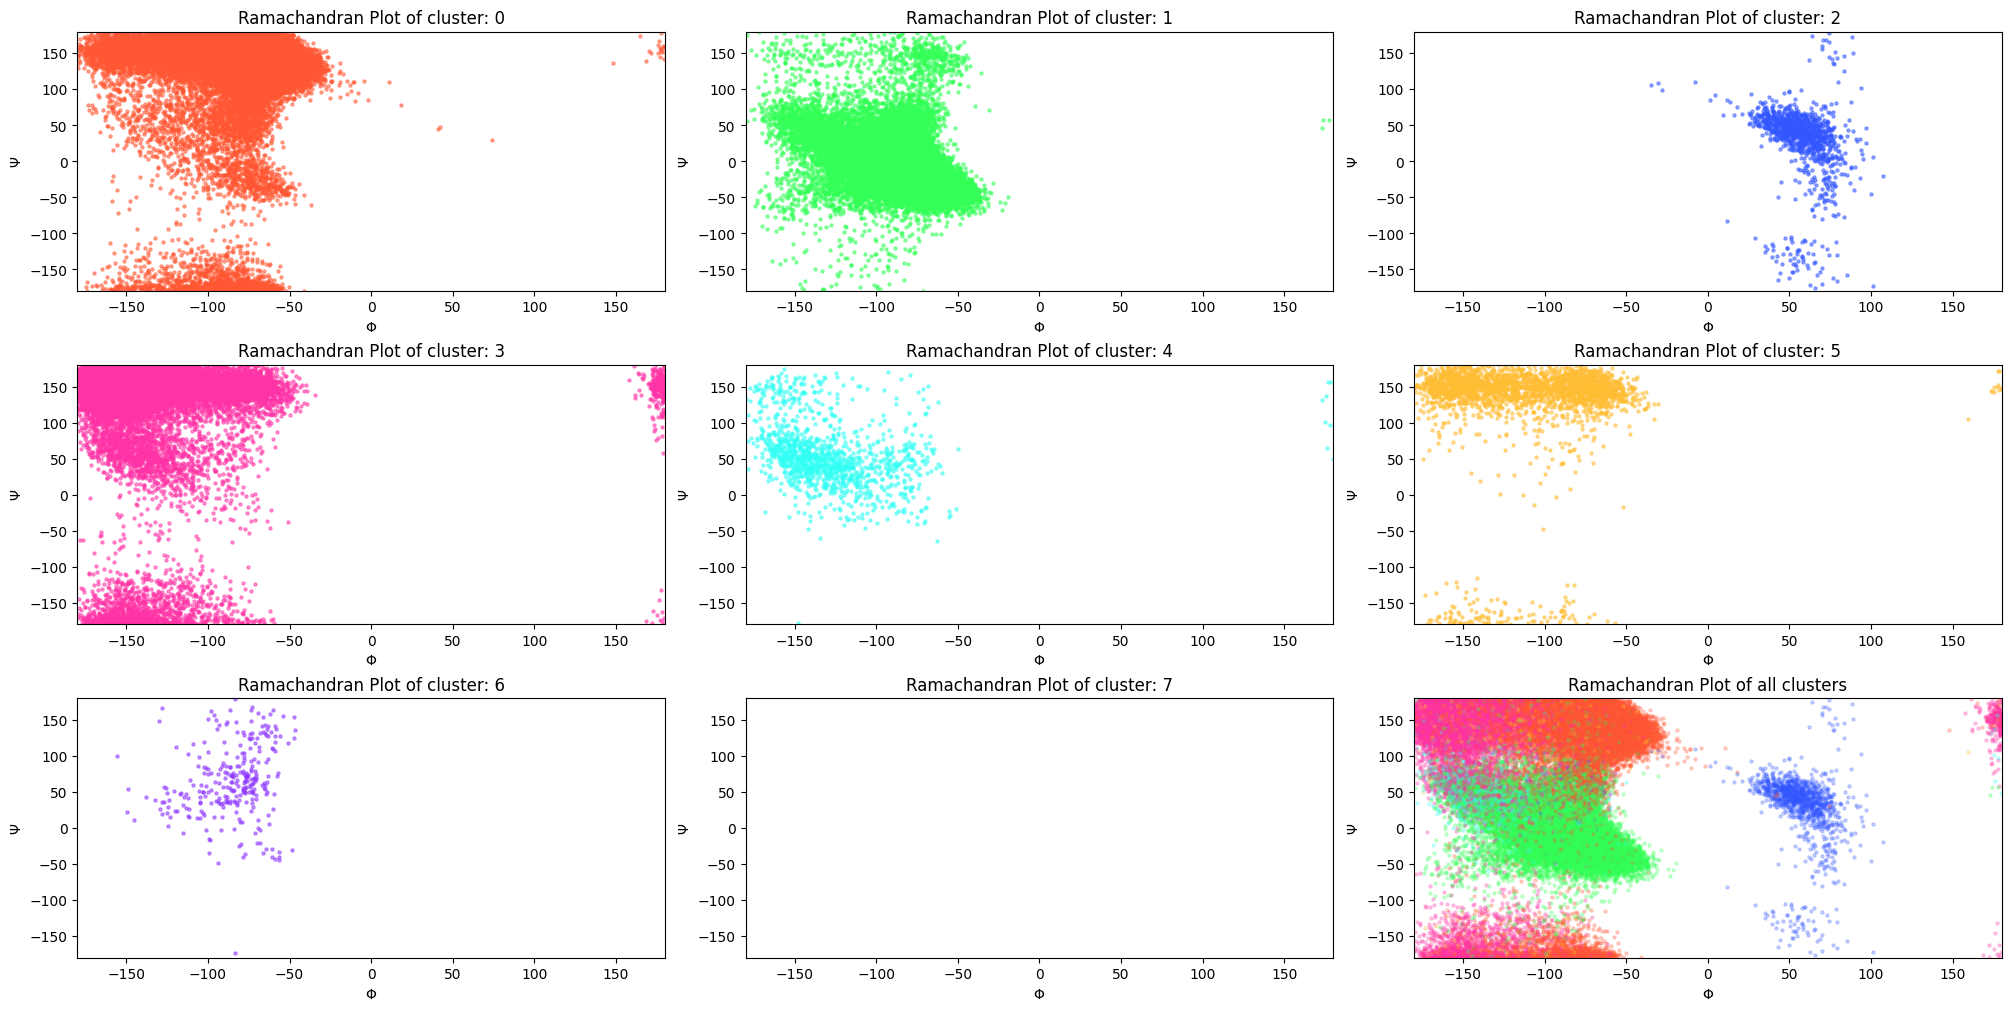

In [26]:
filter_out_all_states = [i for i in all_of_unshifted_states if len(i) != 0]
states = filter_out_all_states
labs = arr

for i in range(len(labs)):
    if labs[i] == 7:
        labs[i] = 0

colors = [
    "#FF5733",  # Red-Orange
    "#33FF57",  # Lime Green
    "#3357FF",  # Blue
    "#FF33A6",  # Pink
    "#33FFF5",  # Cyan
    "#FFBD33",  # Orange
    "#8D33FF",  # Purple
    "#FF5733",  # Red
    "#33FFBD",  # Mint
    "#FFFF33"   # Yellow
]

n_clusters = 8
rows = int(n_clusters/3) + 1

fig, ax = plt.subplots(rows, 3, figsize=(20, 10), layout="constrained")
counter = 0
for i in range(rows):
    for j in range(3):
        if counter==n_clusters:
            for k in range(len(labs)):
                ax[i, j].scatter(states[k][:,0],states[k][:,1], s=5, c=colors[labs[k]],alpha=0.25)
            ax[i, j].set_title("Ramachandran Plot of all clusters")
        else:
            for k in range(len(labs)):
                if labs[k] ==counter:
                    ax[i, j].scatter(states[k][:,0],states[k][:,1], s=5, c=colors[labs[k]],alpha=0.5)
            str1_lst = ['Ramachandran Plot of cluster: ', counter]
            str1 = ''.join(map(str,str1_lst))
            ax[i, j].set_title(str1)
        counter+=1
        ax[i, j].set_xlabel("$\Phi$")
        ax[i, j].set_ylabel("$\Psi$")
        ax[i, j].set_xlim(-180,180)
        ax[i, j].set_ylim(-180,180)


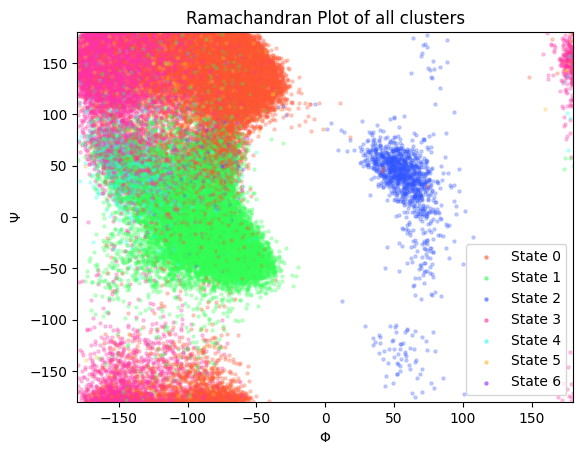

In [56]:

for k in range(len(labs)):
   plt.scatter(states[k][:,0],states[k][:,1], s=5, c=colors[labs[k]],alpha=0.25)
plt.title("Ramachandran Plot of all clusters")
plt.xlabel("$\Phi$")
plt.ylabel("$\Psi$")
plt.xlim(-180,180)
plt.ylim(-180,180)

plt.scatter(-100, 150, s=5, c=colors[0] ,alpha=0.5, label='State 0')
plt.scatter(-100, 0, s=5, c=colors[1] ,alpha=0.5, label='State 1')
plt.scatter(50, 50, s=5, c=colors[2] ,alpha=0.5, label='State 2')
plt.scatter(-150,150, s=5, c=colors[3] ,alpha=0.5, label='State 3')
plt.scatter(-150, 50, s=5, c=colors[4] ,alpha=0.5, label='State 4')
plt.scatter(-125, 150, s=5, c=colors[5] ,alpha=0.5, label='State 5')
plt.scatter(-75, 50, s=5, c=colors[6] ,alpha=0.5, label='State 6')
plt.legend()

In [27]:
new_traj = []
for i in range(len(labs)):
    ar = np.full(len(filter_out_all_states[i]), labs[i])
    new_traj.append(ar)

traj = np.concatenate(new_traj)
print(len(traj))

100000


estimating BayesianMSM:   0%|          | 0/7 [00:00<?, ?it/s]

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xlim'

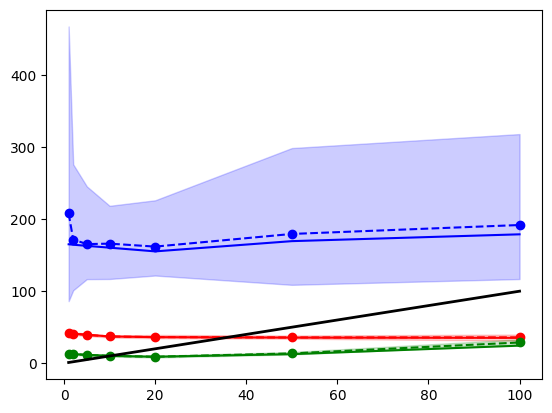

In [28]:
its = pyemma.msm.its(traj, lags=[1, 2, 5, 10, 20, 50,100], nits=3, errors='bayes')
pyemma.plots.plot_implied_timescales(its, ax=plt, units='ps')


estimating MaximumLikelihoodMSM:   0%|          | 0/9 [00:00<?, ?it/s]

TypeError: legend() takes 0-2 positional arguments but 3 were given

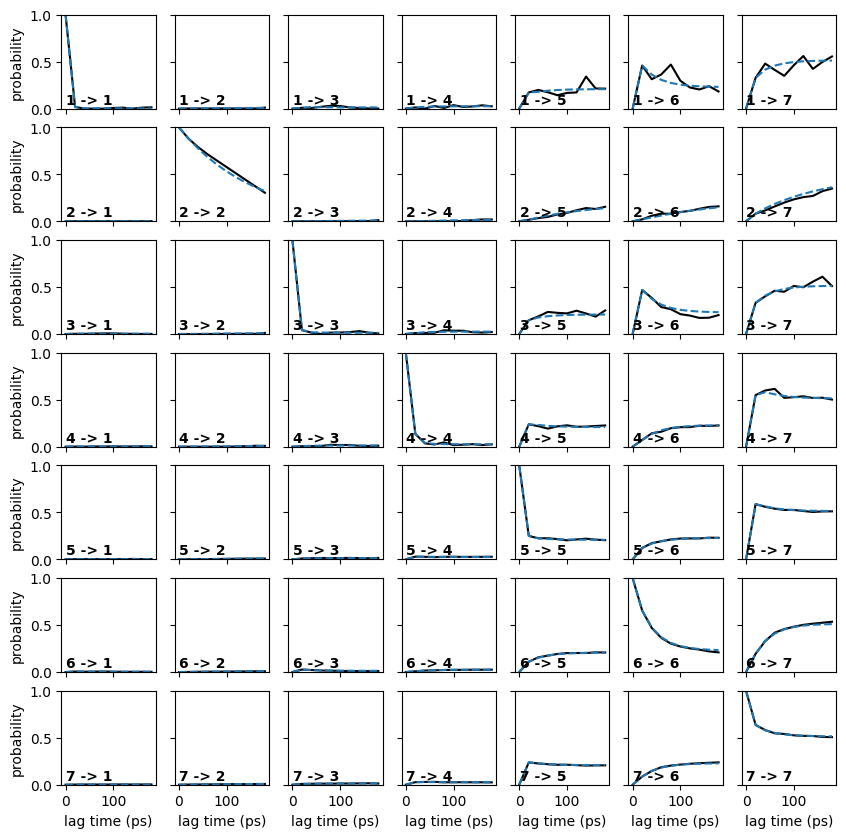

In [31]:
msm_seg = pyemma.msm.estimate_markov_model(traj, lag=20, dt_traj='1 ps')
pyemma.plots.plot_cktest(msm_seg.cktest(7), units='ps');

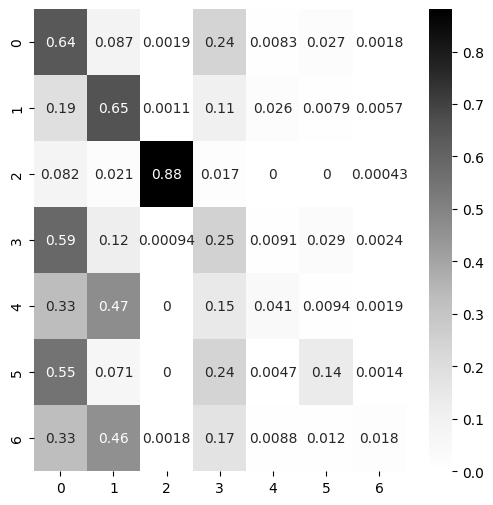

In [32]:
plt.figure(figsize=(6,6))
hm = sns.heatmap(data=msm_seg.transition_matrix,cmap='Greys', annot=True)

# Barycenter MSM

In [33]:
df = pd.read_csv('ADP_data/A_2D_1ps.dat', header=None, skipinitialspace=True, sep=' ', names=['phi', 'psi'])
points = np.array(df)

change_pts_info = pd.read_csv("data/ChangePoints_phi_ws=10_q=0.8_psi_ws=25_q=0.75.txt", delimiter=',',header=None, skipinitialspace=True, names=['CP', 'angle'])

improved_clusters = pd.read_csv("data/ClusterTrajectory_total=100000_Barycenters.txt",header=None, skipinitialspace=False)
arr = np.array(improved_clusters)
arr = arr.flatten()

In [5]:
change_pts_info['angle'][0]

'phi'

In [35]:
list_unshifted = construct_combined_states(points, change_pts_info, 0, 100000)

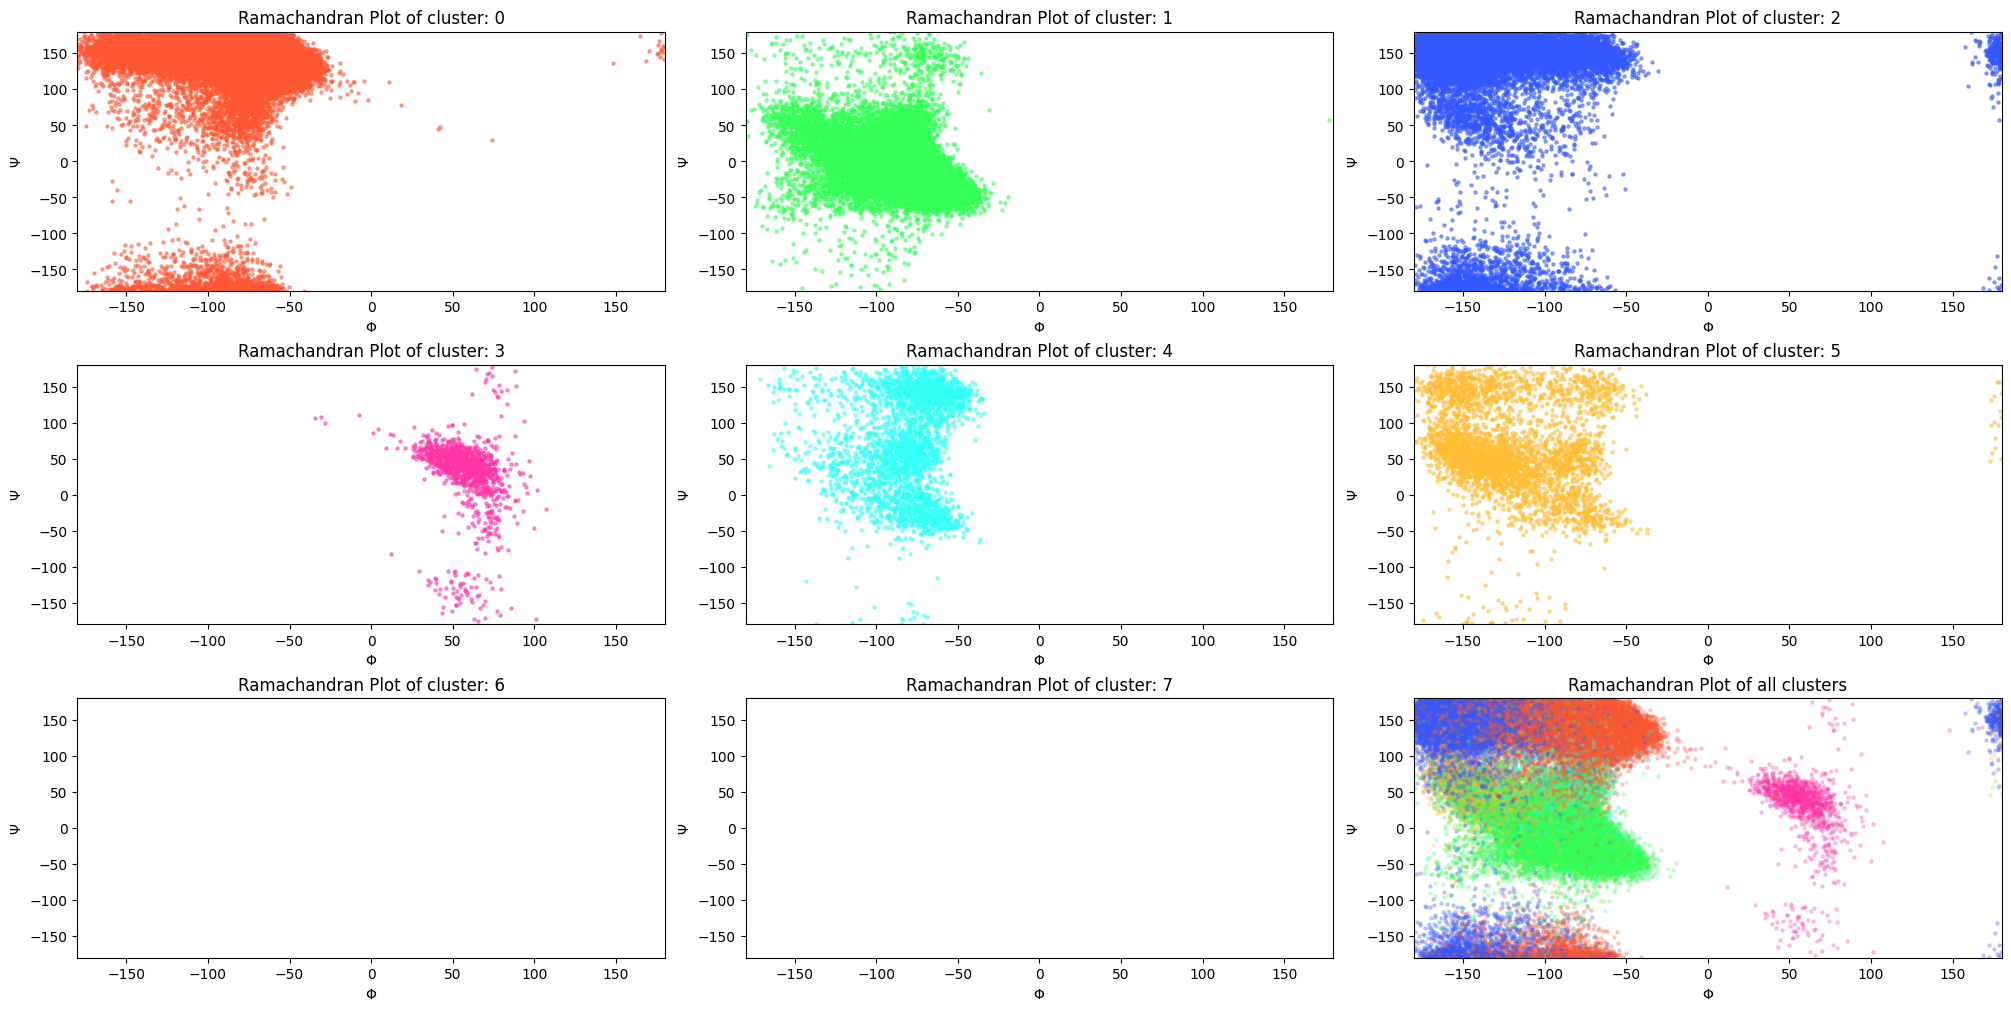

In [38]:
filter_out_all_states = [i for i in all_of_unshifted_states if len(i) != 0]
states = filter_out_all_states
labs = [int(i) for i in arr]

colors = [
    "#FF5733",  # Red-Orange
    "#33FF57",  # Lime Green
    "#3357FF",  # Blue
    "#FF33A6",  # Pink
    "#33FFF5",  # Cyan
    "#FFBD33",  # Orange
    "#8D33FF",  # Purple
    "#FF5733",  # Red
    "#33FFBD",  # Mint
    "#FFFF33"   # Yellow
]

n_clusters = 8
rows = int(n_clusters/3) + 1

fig, ax = plt.subplots(rows, 3, figsize=(20, 10), layout="constrained")
counter = 0
for i in range(rows):
    for j in range(3):
        if counter==n_clusters:
            for k in range(len(labs)):
                ax[i, j].scatter(states[k][:,0],states[k][:,1], s=5, c=colors[labs[k]],alpha=0.25)
            ax[i, j].set_title("Ramachandran Plot of all clusters")
        else:
            for k in range(len(labs)):
                if labs[k] ==counter:
                    ax[i, j].scatter(states[k][:,0],states[k][:,1], s=5, c=colors[labs[k]],alpha=0.5)
            str1_lst = ['Ramachandran Plot of cluster: ', counter]
            str1 = ''.join(map(str,str1_lst))
            ax[i, j].set_title(str1)
        counter+=1
        ax[i, j].set_xlabel("$\Phi$")
        ax[i, j].set_ylabel("$\Psi$")
        ax[i, j].set_xlim(-180,180)
        ax[i, j].set_ylim(-180,180)


In [39]:
new_traj = []
for i in range(len(labs)):
    ar = np.full(len(filter_out_all_states[i]), labs[i])
    new_traj.append(ar)

traj = np.concatenate(new_traj)
print(len(traj))

100000


In [14]:
traj

array([1, 1, 1, ..., 0, 0, 0])

estimating BayesianMSM:   0%|          | 0/7 [00:00<?, ?it/s]

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xlim'

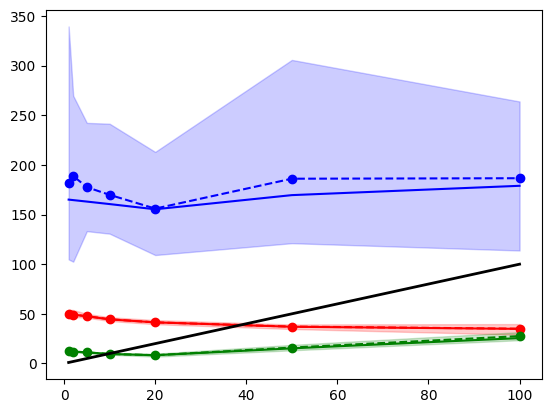

In [42]:
its = pyemma.msm.its(traj, lags=[1, 2, 5, 10, 20, 50,100], nits=3, errors='bayes')
pyemma.plots.plot_implied_timescales(its, ax=plt, units='ps')

estimating MaximumLikelihoodMSM:   0%|          | 0/9 [00:00<?, ?it/s]

TypeError: legend() takes 0-2 positional arguments but 3 were given

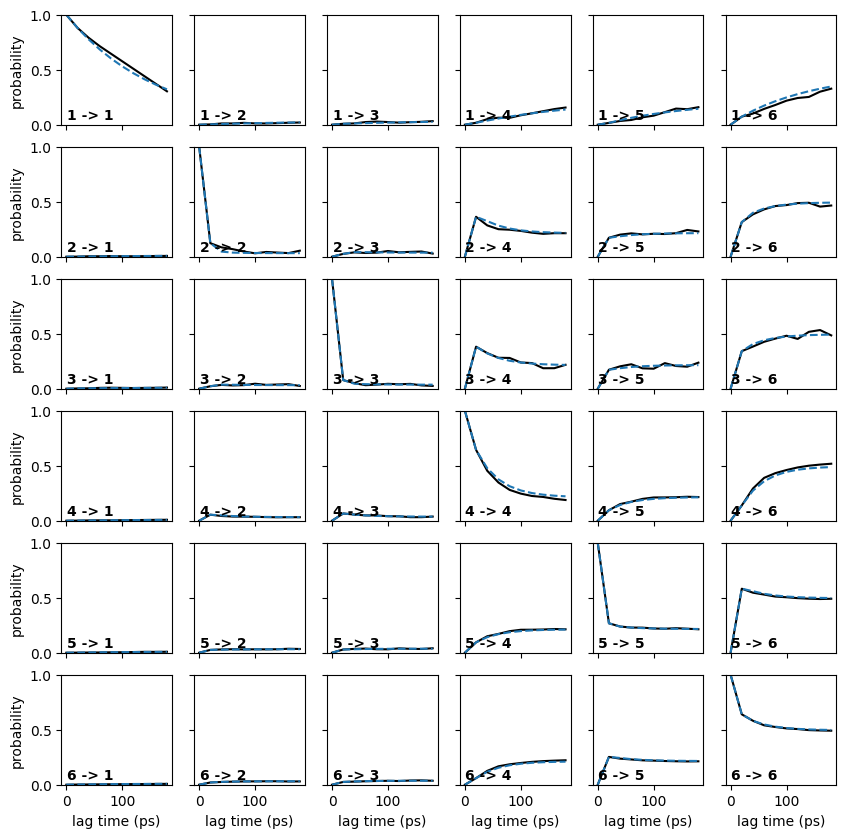

In [44]:
msm_seg = pyemma.msm.estimate_markov_model(traj, lag=20, dt_traj='1 ps')
pyemma.plots.plot_cktest(msm_seg.cktest(6), units='ps');

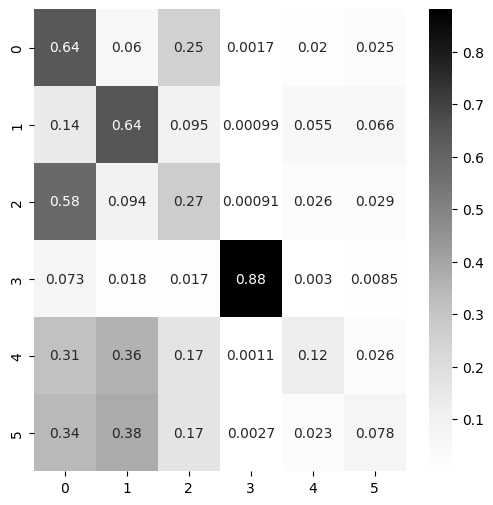

In [45]:
plt.figure(figsize=(6,6))
hm = sns.heatmap(data=msm_seg.transition_matrix,cmap='Greys', annot=True)